## Skeleton Code

The code below provides a skeleton for the model building & training component of your project. You can add/remove/build on code however you see fit, this is meant as a starting point.

In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
from glob import glob
%matplotlib inline
import matplotlib.pyplot as plt
from itertools import chain
from sklearn.model_selection import train_test_split
from IPython.display import Image, display
from random import sample
from sklearn.metrics import roc_curve
from sklearn.metrics import auc
from sklearn.metrics import confusion_matrix

from keras.preprocessing.image import ImageDataGenerator
from keras.layers import GlobalAveragePooling2D, Dense, Dropout, Flatten, Conv2D, MaxPooling2D
from keras.models import Sequential, Model
from keras.applications.vgg16 import VGG16
from keras.applications.resnet import ResNet50 
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint, LearningRateScheduler, EarlyStopping, ReduceLROnPlateau
##Import any other stats/DL/ML packages you may need here. E.g. Keras, scikit-learn, etc.

Using TensorFlow backend.


## Do some early processing of your metadata for easier model training:

In [2]:
## Below is some helper code to read all of your full image filepaths into a dataframe for easier manipulation
## Load the NIH data to all_xray_df
data = pd.read_csv('/data/Data_Entry_2017.csv')
all_image_paths = {os.path.basename(x): x for x in 
                   glob(os.path.join('/data','images*', '*', '*.png'))}
print('Scans found:', len(all_image_paths), ', Total Headers', data.shape[0])
data['path'] = data['Image Index'].map(all_image_paths.get)
data.sample(10)

Scans found: 112120 , Total Headers 112120


,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImage[Width,Height],OriginalImagePixelSpacing[x,y],Unnamed: 11,path
14003,00003614_000.png,Emphysema,0,3614,56,M,PA,2674,2991,0.143000,0.143000,NaN,/data/images_002/images/00003614_000.png
12894,00003383_002.png,Infiltration,2,3383,52,M,AP,2500,2048,0.168000,0.168000,NaN,/data/images_002/images/00003383_002.png
51848,00013101_000.png,Cardiomegaly|Fibrosis|Nodule,0,13101,77,M,PA,2048,2500,0.168000,0.168000,NaN,/data/images_006/images/00013101_000.png
110023,00029943_004.png,Pneumothorax,4,29943,65,F,PA,2021,2021,0.194311,0.194311,NaN,/data/images_012/images/00029943_004.png
81875,00020146_006.png,Pneumothorax,6,20146,22,M,PA,2992,2991,0.143000,0.143000,NaN,/data/images_009/images/00020146_006.png
81378,00019990_002.png,Infiltration,2,19990,23,F,PA,2714,2991,0.143000,0.143000,NaN,/data/images_009/images/00019990_002.png
107716,00029106_000.png,Nodule,0,29106,34,M,PA,2021,2021,0.194317,0.194317,NaN,/data/images_012/images/00029106_000.png
42650,00010988_001.png,Atelectasis,1,10988,62,M,AP,2500,2048,0.168000,0.168000,NaN,/data/images_005/images/00010988_001.png
32140,00008401_007.png,No Finding,7,8401,57,F,PA,2992,2991,0.143000,0.143000,NaN,/data/images_004/images/00008401_007.png
100536,00026676_000.png,Infiltration,0,26676,62,F,PA,2706,2433,0.143000,0.143000,NaN,/data/images_011/images/00026676_000.png


In [3]:
data.describe()

,Follow-up #,Patient ID,Patient Age,OriginalImage[Width,Height],OriginalImagePixelSpacing[x,y],Unnamed: 11
count,112120.000000,112120.000000,112120.000000,112120.000000,112120.000000,112120.000000,112120.000000,0.0
mean,8.573751,14346.381743,46.901463,2646.078844,2486.438842,0.155649,0.155649,NaN
std,15.406320,8403.876972,16.839923,341.246429,401.268227,0.016174,0.016174,NaN
min,0.000000,1.000000,1.000000,1143.000000,966.000000,0.115000,0.115000,NaN
25%,0.000000,7310.750000,35.000000,2500.000000,2048.000000,0.143000,0.143000,NaN
50%,3.000000,13993.000000,49.000000,2518.000000,2544.000000,0.143000,0.143000,NaN
75%,10.000000,20673.000000,59.000000,2992.000000,2991.000000,0.168000,0.168000,NaN
max,183.000000,30805.000000,414.000000,3827.000000,4715.000000,0.198800,0.198800,NaN


In [4]:
data['Image Index'][0]

'00000001_000.png'

In [5]:
## Here you may want to create some extra columns in your table with binary indicators of certain diseases 
## rather than working directly with the 'Finding Labels' column


all_labels = np.unique(list(chain(*data['Finding Labels'].map(lambda x: x.split('|')).tolist())))
all_labels = [x for x in all_labels if len(x)>0]
print('All Labels ({}): {}'.format(len(all_labels), all_labels))
for c_label in all_labels:
    if len(c_label)>1: # leave out empty labels
        data[c_label] = data['Finding Labels'].map(lambda finding: 1.0 if c_label in finding else 0)
data.sample(3)

# Todo

All Labels (15): ['Atelectasis', 'Cardiomegaly', 'Consolidation', 'Edema', 'Effusion', 'Emphysema', 'Fibrosis', 'Hernia', 'Infiltration', 'Mass', 'No Finding', 'Nodule', 'Pleural_Thickening', 'Pneumonia', 'Pneumothorax']


,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImage[Width,Height],OriginalImagePixelSpacing[x,...,Emphysema,Fibrosis,Hernia,Infiltration,Mass,No Finding,Nodule,Pleural_Thickening,Pneumonia,Pneumothorax
99687,00026412_000.png,Infiltration,0,26412,23,M,AP,3056,2544,0.139,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
95498,00025107_000.png,Nodule,0,25107,49,M,PA,2992,2991,0.143,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
87065,00021486_001.png,No Finding,1,21486,61,F,PA,2990,2777,0.143,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0


In [6]:
## Here we can create a new column called 'pneumonia_class' that will allow us to look at 
## images with or without pneumonia for binary classification
data.drop('Finding Labels', axis = 'columns', inplace = True)
# Todo
#data["Pneumonia Class"] = data["Pneumonia"]
#event_dictionary ={1:'Penumonia',0: 'No Pneumonia'} 
  
#data['Pneumonia Class'] = data['Pneumonia'].map(event_dictionary)
#data.drop('Pneumonia', axis=1, inplace =  True)
IMG_SIZE = (224, 224)
data.head()

,Image Index,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImage[Width,Height],OriginalImagePixelSpacing[x,y],...,Emphysema,Fibrosis,Hernia,Infiltration,Mass,No Finding,Nodule,Pleural_Thickening,Pneumonia,Pneumothorax
0,00000001_000.png,0,1,58,M,PA,2682,2749,0.143,0.143,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,00000001_001.png,1,1,58,M,PA,2894,2729,0.143,0.143,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,00000001_002.png,2,1,58,M,PA,2500,2048,0.168,0.168,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,00000002_000.png,0,2,81,M,PA,2500,2048,0.171,0.171,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
4,00000003_000.png,0,3,81,F,PA,2582,2991,0.143,0.143,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


## Create your training and testing data:

In [7]:
def create_splits(vargs):
    
    ## Either build your own or use a built-in library to split your original dataframe into two sets 
    ## that can be used for training and testing your model
    ## It's important to consider here how balanced or imbalanced you want each of those sets to be
    ## for the presence of pneumonia
    
    # Todo
    
    train_data, val_data = train_test_split(data, test_size=0.2, stratify = data['Pneumonia'])
    
    pneumonia_inds = train_data[train_data['Pneumonia']==1].index.tolist()
    no_pneumonia = train_data[train_data['Pneumonia']==0].index.tolist()
    np_sample = sample(no_pneumonia,len(pneumonia_inds))
    train_data = train_data.loc[pneumonia_inds + np_sample]
    
    pneumonia_inds = val_data[val_data['Pneumonia']==1].index.tolist()
    no_pneumonia = val_data[val_data['Pneumonia']==0].index.tolist()
    np_sample = sample(no_pneumonia,len(pneumonia_inds))
    val_data = val_data.loc[pneumonia_inds + 4*np_sample]
    
    return train_data, val_data

# Now we can begin our model-building & training

#### First suggestion: perform some image augmentation on your data

In [8]:
def my_image_augmentation(vargs):
    
    ## recommendation here to implement a package like Keras' ImageDataGenerator
    ## with some of the built-in augmentations 
    
    ## keep an eye out for types of augmentation that are or are not appropriate for medical imaging data
    ## Also keep in mind what sort of augmentation is or is not appropriate for testing vs validation data
    
    ## STAND-OUT SUGGESTION: implement some of your own custom augmentation that's *not*
    ## built into something like a Keras package
    
    # Todo
    my_idg = ImageDataGenerator(rescale=1. / 255.0,
                              horizontal_flip = True,
                              vertical_flip = False, 
                              height_shift_range= 0.1, 
                              width_shift_range=0.1, 
                              rotation_range=20, 
                              shear_range = 0.1,
                              zoom_range=0.1)
    return my_idg


def make_train_gen(vargs):
    
    ## Create the actual generators using the output of my_image_augmentation for your training data
    ## Suggestion here to use the flow_from_dataframe library, e.g.:
    my_train_idg = my_image_augmentation(vargs)
  
    train_gen = my_train_idg.flow_from_dataframe(dataframe=vargs, 
                                          directory=None, 
                                          x_col = 'path',
                                          y_col = 'Pneumonia',
                                          class_mode = 'raw',
                                          target_size = IMG_SIZE, 
                                          batch_size = 32
                                          )
     # Todo
    return train_gen


def make_val_gen(vargs):
    
    val_idg = ImageDataGenerator(rescale=1. / 255.0,
                                 )
    
    val_gen = val_idg.flow_from_dataframe(dataframe=vargs, 
                                         directory=None, 
                                         x_col = 'path',
                                         y_col = 'Pneumonia',
                                         class_mode = 'raw',
                                         target_size = IMG_SIZE, 
                                         batch_size = 16) ## We've only been provided with 6 validation images

    return val_gen

In [9]:
## May want to pull a single large batch of random validation data for testing after each epoch:
train_data, val_data = create_splits(data)
#val_data['Pneumonia'].sum()/len(val_data)
val_gen = make_val_gen(val_data)
valX, valY = val_gen.next()

Found 1430 validated image filenames.


Found 2290 validated image filenames.


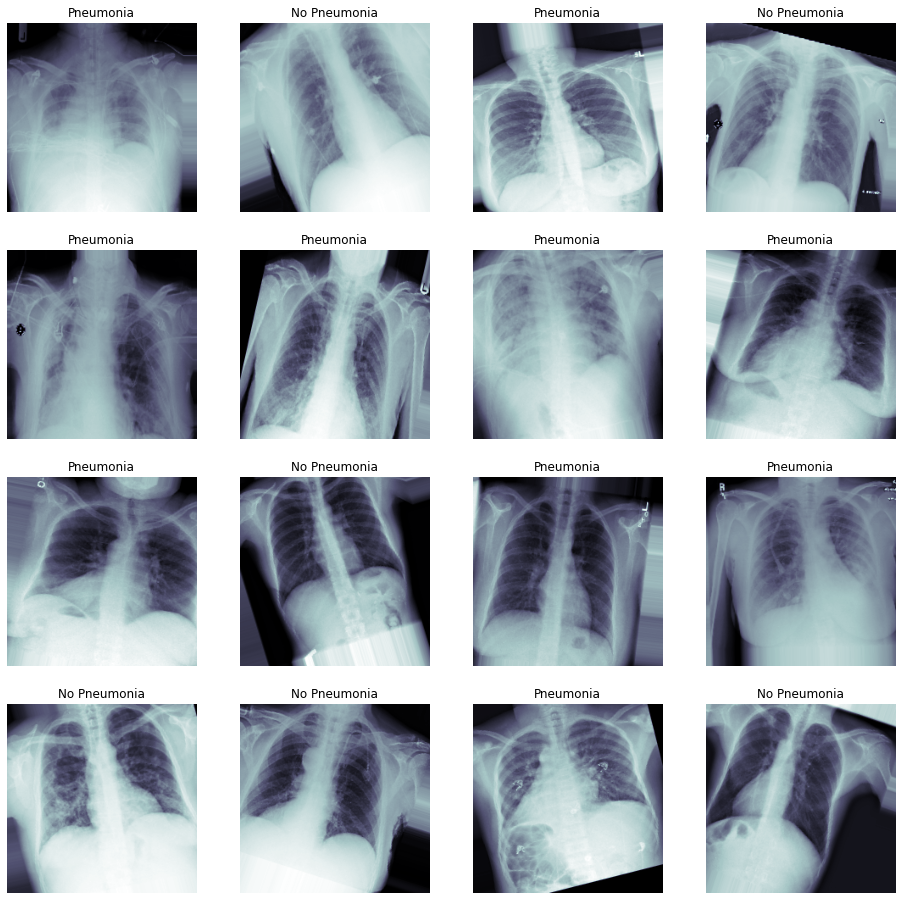

In [10]:
## May want to look at some examples of our augmented training data. 
## This is helpful for understanding the extent to which data is being manipulated prior to training, 
## and can be compared with how the raw data look prior to augmentation

t_x, t_y = next(make_train_gen(train_data))
fig, m_axs = plt.subplots(4, 4, figsize = (16, 16))
for (c_x, c_y, c_ax) in zip(t_x, t_y, m_axs.flatten()):
    c_ax.imshow(c_x[:,:,0], cmap = 'bone')
    if c_y == 1: 
        c_ax.set_title('Pneumonia')
    else:
        c_ax.set_title('No Pneumonia')
    c_ax.axis('off')

## Build your model: 

Recommendation here to use a pre-trained network downloaded from Keras for fine-tuning

In [11]:
def load_pretrained_model(vargs):
    
    model = VGG16(include_top=True, weights='imagenet')
    transfer_layer = model.get_layer('block5_pool')
    vgg_model = Model(inputs = model.input, outputs = transfer_layer.output)
    
    # Todo

    return vgg_model


In [12]:
def build_my_model(vargs):

    # ....add your pre-trained model, and then whatever additional layers you think you might
    # want for fine-tuning (Flatteen, Dense, Dropout, etc.)
    vgg_model = load_pretrained_model(vargs)
    new_model = Sequential()
    # if you want to compile your model within this function, consider which layers of your pre-trained model, 
    # you want to freeze before you compile 
    for layer in vgg_model.layers[0:17]:
        layer.trainable = False
    # also make sure you set your optimizer, loss function, and metrics to monitor
    # Add the convolutional part of the VGG16 model from above.
    new_model.add(vgg_model)

    # Flatten the output of the VGG16 model because it is from a
    # convolutional layer.
    new_model.add(Flatten())

    # Add a dense (aka. fully-connected) layer.
    # This is for combining features that the VGG16 model has
    # recognized in the image.
    #new_model.add(Dense(1, activation='sigmoid'))
    # Todo
    
    # Add a dropout-layer which may prevent overfitting and
# improve generalization ability to unseen data e.g. the test-set.
    new_model.add(Dropout(0.3))

# Add a dense (aka. fully-connected) layer.
# This is for combining features that the VGG16 model has
# recognized in the image.
    new_model.add(Dense(1024, activation='relu'))
    
# Add a dropout-layer which may prevent overfitting and
# improve generalization ability to unseen data e.g. the test-set.
    new_model.add(Dropout(0.5))

# Add a dense (aka. fully-connected) layer.
# This is for combining features that the VGG16 model has
# recognized in the image.
    new_model.add(Dense(512, activation='relu'))

# Add a dropout-layer which may prevent overfitting and
# improve generalization ability to unseen data e.g. the test-set.
    new_model.add(Dropout(0.3))

# Add a dense (aka. fully-connected) layer.
# This is for combining features that the VGG16 model has
# recognized in the image.
    new_model.add(Dense(256, activation='relu'))

# Add a dense (aka. fully-connected) layer.
# Change the activation function to sigmoid 
# so output of the last layer is in the range of [0,1] 
    new_model.add(Dense(1, activation='sigmoid'))

    optimizer = Adam(lr=1e-5)
    loss = 'binary_crossentropy'
    metrics = ['binary_accuracy']
    
    new_model.compile(optimizer=optimizer, loss=loss, metrics=metrics)
    
    return new_model



## STAND-OUT Suggestion: choose another output layer besides just the last classification layer of your modele
## to output class activation maps to aid in clinical interpretation of your model's results

In [13]:
## Below is some helper code that will allow you to add checkpoints to your model,
## This will save the 'best' version of your model by comparing it to previous epochs of training

## Note that you need to choose which metric to monitor for your model's 'best' performance if using this code. 
## The 'patience' parameter is set to 10, meaning that your model will train for ten epochs without seeing
## improvement before quitting

# Todo

weight_path="{}_my_model.best.hdf5".format('xray_class')

CHOOSE_METRIC_TO_MONITOR_FOR_PERFORMANCE = 'val_loss'
CHOOSE_MIN_OR_MAX_FOR_YOUR_METRIC = 'auto'

checkpoint = ModelCheckpoint(weight_path, 
                              monitor= CHOOSE_METRIC_TO_MONITOR_FOR_PERFORMANCE, 
                              verbose=1, 
                              save_best_only=True, 
                              mode= CHOOSE_MIN_OR_MAX_FOR_YOUR_METRIC, 
                              save_weights_only = True)
early = EarlyStopping(monitor= CHOOSE_METRIC_TO_MONITOR_FOR_PERFORMANCE, 
                       mode= 'auto', 
                       patience=10)

callbacks_list = [checkpoint, early]

### Start training! 

In [14]:
## train your model

# Todo
my_model = build_my_model(data)
train_gen = make_train_gen(train_data)
history = my_model.fit_generator(train_gen, 
                           validation_data = (valX, valY), 
                           epochs = 20, 
                           callbacks = callbacks_list)

553467904/553467096 [==============================] - 12s 0us/step
Found 2290 validated image filenames.
Epoch 1/20
72/72 [==============================] - 66s 915ms/step - loss: 0.7440 - binary_accuracy: 0.5070 - val_loss: 0.6765 - val_binary_accuracy: 0.6250

Epoch 00001: val_loss improved from inf to 0.67654, saving model to xray_class_my_model.best.hdf5
Epoch 2/20
72/72 [==============================] - 57s 793ms/step - loss: 0.7081 - binary_accuracy: 0.5306 - val_loss: 0.7064 - val_binary_accuracy: 0.5625

Epoch 00002: val_loss did not improve from 0.67654
Epoch 3/20
72/72 [==============================] - 59s 819ms/step - loss: 0.7073 - binary_accuracy: 0.5402 - val_loss: 0.6893 - val_binary_accuracy: 0.5625

Epoch 00003: val_loss did not improve from 0.67654
Epoch 4/20
72/72 [==============================] - 59s 823ms/step - loss: 0.7015 - binary_accuracy: 0.5271 - val_loss: 0.6439 - val_binary_accuracy: 0.6250

Epoch 00004: val_loss improved from 0.67654 to 0.64388, saving

##### After training for some time, look at the performance of your model by plotting some performance statistics:

Note, these figures will come in handy for your FDA documentation later in the project

In [15]:
## After training, make some predictions to assess your model's overall performance
## Note that detecting pneumonia is hard even for trained expert radiologists, 
## so there is no need to make the model perfect.
my_model.load_weights(weight_path)
pred_Y = my_model.predict(valX, batch_size = 32, verbose = True)

16/16 [==============================] - 0s 15ms/step


In [16]:
def plot_auc(t_y, p_y):
    
    ## Hint: can use scikit-learn's built in functions here like roc_curve
    
    # Todo
    
   # roc_auc_score(t_y, p_y, labels='Pneumonia')
    fpr, tpr, thresholds = roc_curve(t_y, p_y)
    roc_auc = auc(fpr, tpr)
   
    plt.title('Receiver Operating Characteristic')
    plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
    plt.legend(loc = 'lower right')
    plt.plot([0, 1], [0, 1],'r--')
    plt.xlim([0, 1])
    plt.ylim([0, 1])
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.show()
    return 

## what other performance statistics do you want to include here besides AUC? 


#Also consider plotting the history of your model training:

def plot_history(history):
    N = len(history.history["loss"])
    plt.style.use("ggplot")
    plt.figure()
    plt.plot(np.arange(0, N), history.history["loss"], label="train_loss")
    plt.plot(np.arange(0, N), history.history["val_loss"], label="val_loss")
    plt.plot(np.arange(0, N), history.history["binary_accuracy"], label="train_acc")
    plt.plot(np.arange(0, N), history.history["val_binary_accuracy"], label="val_acc")
    plt.title("Training Loss and Accuracy on Dataset")
    plt.xlabel("Epoch #")
    plt.ylabel("Loss/Accuracy")
    plt.legend(loc="lower left")
    # Todo
    return

In [17]:
valY

array([0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])

In [18]:
pred_Y.shape

(16, 1)

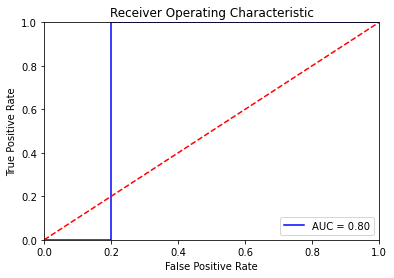

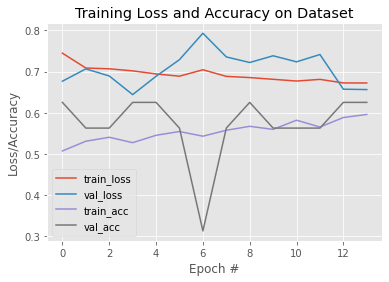

In [19]:
## plot figures
plot_auc(valY,pred_Y)
plot_history(history)
# Todo

Once you feel you are done training, you'll need to decide the proper classification threshold that optimizes your model's performance for a given metric (e.g. accuracy, F1, precision, etc.  You decide) 

In [73]:
#confusion matrix
from sklearn.metrics import f1_score, precision_recall_curve
from sklearn.preprocessing import binarize

precision, recall, thresholds = precision_recall_curve(valY.astype(int), pred_Y)
thresholds1 = np.linspace(0.3,0.8,100)
f1_scores = []
max_f1_score = 0
max_threshold = 0
for i in thresholds1:
    f1 = f1_score(valY.astype(int), binarize(pred_Y,i))
    f1_scores.append(f1)
    if(f1>max_f1_score):
        max_f1_score = f1
        max_threshold = i

Text(0.5, 1.0, 'F1 vs threshold plot')

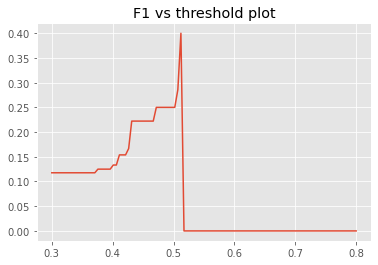

In [74]:
plt.plot(thresholds1, f1_scores)
plt.title("F1 vs threshold plot")

In [79]:
max_threshold

0.5121212121212121

In [76]:
precision.shape

(5,)

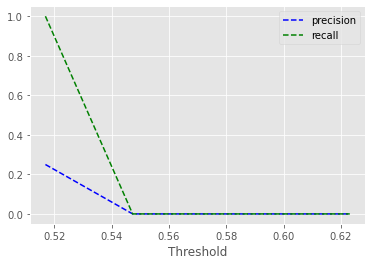

In [77]:
plt.plot(thresholds, precision[:-1], 'b--' , label = 'precision')
plt.plot(thresholds, recall[:-1], 'g--' , label = 'recall')
plt.xlabel('Threshold')
plt.legend()

In [80]:
## Find the threshold that optimize your model's performance,
## and use that threshold to make binary classification. Make sure you take all your metrics into consideration.
YOUR_THRESHOLD = max_threshold
# Todo

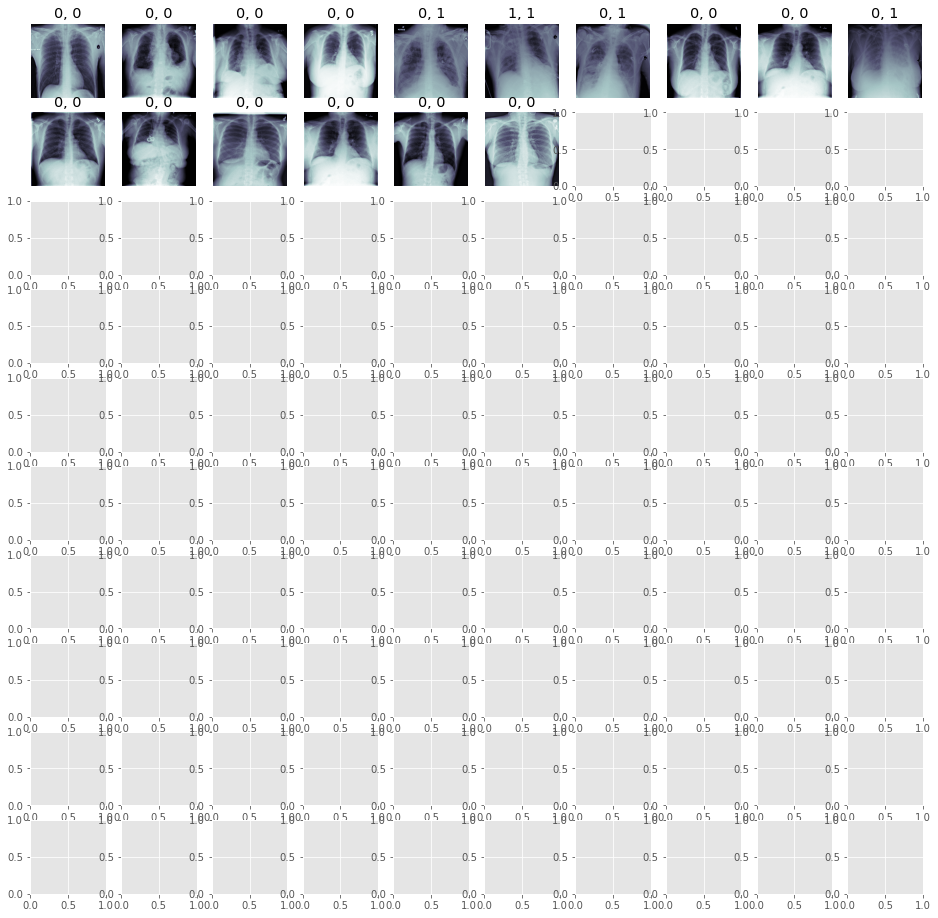

In [81]:
## Let's look at some examples of true vs. predicted with our best model: 

# Todo

fig, m_axs = plt.subplots(10, 10, figsize = (16, 16))
i = 0
for (c_x, c_y, c_ax) in zip(valX[0:100], valY[0:100], m_axs.flatten()):
    c_ax.imshow(c_x[:,:,0], cmap = 'bone')
    if c_y == 1: 
        if pred_Y[i] > YOUR_THRESHOLD:
            c_ax.set_title('1, 1')
        else:
            c_ax.set_title('1, 0')
    else:
        if pred_Y[i] > YOUR_THRESHOLD: 
            c_ax.set_title('0, 1')
        else:
            c_ax.set_title('0, 0')
    c_ax.axis('off')
    i=i+1

In [82]:
## Just save model architecture to a .json:

model_json = my_model.to_json()
with open("my_model.json", "w") as json_file:
    json_file.write(model_json)